<a href="https://colab.research.google.com/github/gabriellemacinnes/stock_predictions/blob/main/MAIS_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [38]:
'''
!wget https://raw.githubusercontent.com/gabriellemacinnes/stock_predictions/main/HistoricalQuotes.csv

with open('HistoricalQuotes.csv') as csv_file:
  csv_reader = csv.reader(csv_file)
  colnames = next(csv_reader)  # skip column names
  data = list(csv_reader)
'''

df = pd.read_csv('https://raw.githubusercontent.com/gabriellemacinnes/stock_predictions/main/HistoricalQuotes.csv')
df.columns = df.columns.str.strip()
df.drop(['Volume','Open','Low','High'], axis=1, inplace=True)
df.rename(columns={'Close/Last':'Close'}, inplace=True)
df['Close'] = pd. to_numeric(df['Close'].str[2:])
df['Date'] = pd.to_datetime(df['Date'])

data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .95 ))
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(np.array(data).reshape(-1,1))
df['Close'] = data
l = (int)(len(df) * 0.65)
df = df.iloc[::-1]
df.reset_index(inplace = True, drop = True)
df.iloc[:l].head()


,Date,Close
0,2010-03-01,0.000067
1,2010-03-02,0.000000
2,2010-03-03,0.000231
3,2010-03-04,0.000894
4,2010-03-05,0.004852


In [93]:
epoch = 10
timestep = 50
target_size = 1
batch_size = 10
data_train = df.iloc[:l]
data_test = df.iloc[l:]

def build_training_data(dataset, timestep, target_size):

    data = []
    labels = []

    for i in range(timestep, len(dataset) - target_size):
        data.append(dataset[i - timestep: i])
        labels.append(dataset[i:i + target_size])

    data = np.array(data)
    labels = np.array(labels)
    return data, labels
'''
def build_test_data(dataset, timestep, target_size):
    test_data = []

    for i in range(timestep, len(dataset) - target_size):
        test_data.append(dataset[i - timestep: i])
        test_data = np.array(test_data)
    test_data = np.array(test_data)
    return test_data
'''

dataset = data_train['Close'].values
data, labels = build_training_data(dataset, timestep, target_size)

dataset_test = data_test['Close'].values
test_data, test_labels = build_training_data(dataset_test, timestep, target_size)
print(dataset.shape)
print(data.shape)

'''
for i in range(dataset.shape[0]):
  dataset[i,0] = dataset[i,0].to_pydatetime()
#print(dataset)

d = data[:5]
print(data[200].shape)
print(data[200][49:].shape)
np.concatenate([data[200][49:], labels[200]])[:,0]
'''

(1636,)
(1585, 50)


'\nfor i in range(dataset.shape[0]):\n  dataset[i,0] = dataset[i,0].to_pydatetime()\n#print(dataset)\n\nd = data[:5]\nprint(data[200].shape)\nprint(data[200][49:].shape)\nnp.concatenate([data[200][49:], labels[200]])[:,0]\n'

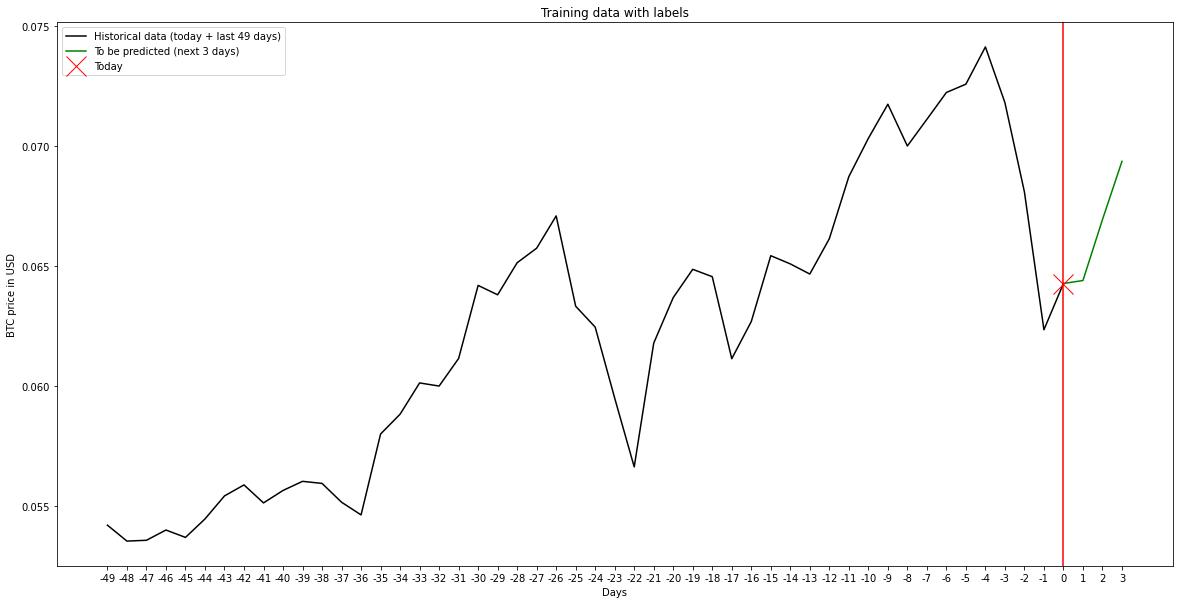

In [78]:
plt.rcParams["figure.figsize"] = (20,10)

day = 200
#print(data[day])
plt.plot(range(0, 50), data[day], 'k-', label = 'Historical data (today + last 49 days)')
plt.plot(range(49, 53), np.concatenate([data[day][49:], labels[day]]), 'g-', label = 'To be predicted (next 3 days)')
plt.axvline(x=49, c = 'r')
plt.plot(49, data[day][49], 'rx', markersize = 20, label = "Today")
plt.xticks(range(0, 53), range(-49, 4))

plt.title('Training data with labels')
plt.xlabel('Days')
plt.ylabel('BTC price in USD')
plt.legend()
plt.show()

In [86]:
# split into train/val/test
data2 = data.reshape((-1, 50, 1))
labels2 = labels.reshape((-1, 3))
print(data2.shape, labels2.shape)

test_data2 = test_data.reshape((-1, 50, 1))

model = Sequential([LSTM(24, input_shape=(50, 1), return_sequences = True),
    # put the rest of the layers here
    Dense(1, activation='linear')])
#model.add(LSTM(units=Y_train, input_size=(batch_size, timestep, X_train[:,1]), stateful=True, return_sequences=False))

(1583, 50, 1) (1583, 3)


In [66]:


model.compile(optimizer='adam', loss='mse')
model.fit(data2, labels2[:,0], epochs=10, verbose=1)

  


Epoch 1/10
50/50 [==============================] - 4s 21ms/step - loss: 0.0126
Epoch 2/10
50/50 [==============================] - 1s 20ms/step - loss: 0.0086
Epoch 3/10
50/50 [==============================] - 1s 20ms/step - loss: 0.0083
Epoch 4/10
50/50 [==============================] - 1s 20ms/step - loss: 0.0082
Epoch 5/10
50/50 [==============================] - 1s 20ms/step - loss: 0.0082
Epoch 6/10
50/50 [==============================] - 1s 20ms/step - loss: 0.0082
Epoch 7/10
50/50 [==============================] - 1s 21ms/step - loss: 0.0081
Epoch 8/10
50/50 [==============================] - 1s 21ms/step - loss: 0.0081
Epoch 9/10
50/50 [==============================] - 1s 21ms/step - loss: 0.0081
Epoch 10/10
50/50 [==============================] - 1s 21ms/step - loss: 0.0080


In [99]:
def pred():
  output = []
  for x in test_data2:
    temp_input = list(x)
    y = []
    i = 0

    while(i < target_size):
      if(len(temp_input) > timestep):
        x = np.array(temp_input[1:])
        x = x.reshape((1, timestep, 1))
        y_h = model.predict(x, verbose=0)
        temp_input.append(y_h[0,0])
        temp_input = temp_input[1:]
        y.append(y_h[0,0])
        i+=1
      else:
        x = x.reshape((1, timestep, 1))
        y_h = model.predict(x, verbose=0)
        temp_input.append(y_h[0,0])
        y.append(y_h[0,0])
        i+=1

    output.append(y)
  return np.array(output)
#print(data2.shape, test_data2[0].shape)
#predictions = pred()
#predictions

#print(data_test.shape)
# Reshape the data
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1 ))
#data_test = np.array(data_test).reshape((882, 2, 1 ))

# Get the models predicted price values 
predictions = model.predict(test_data)
#predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - test_labels) ** 2)))
rmse

ValueError: ignored

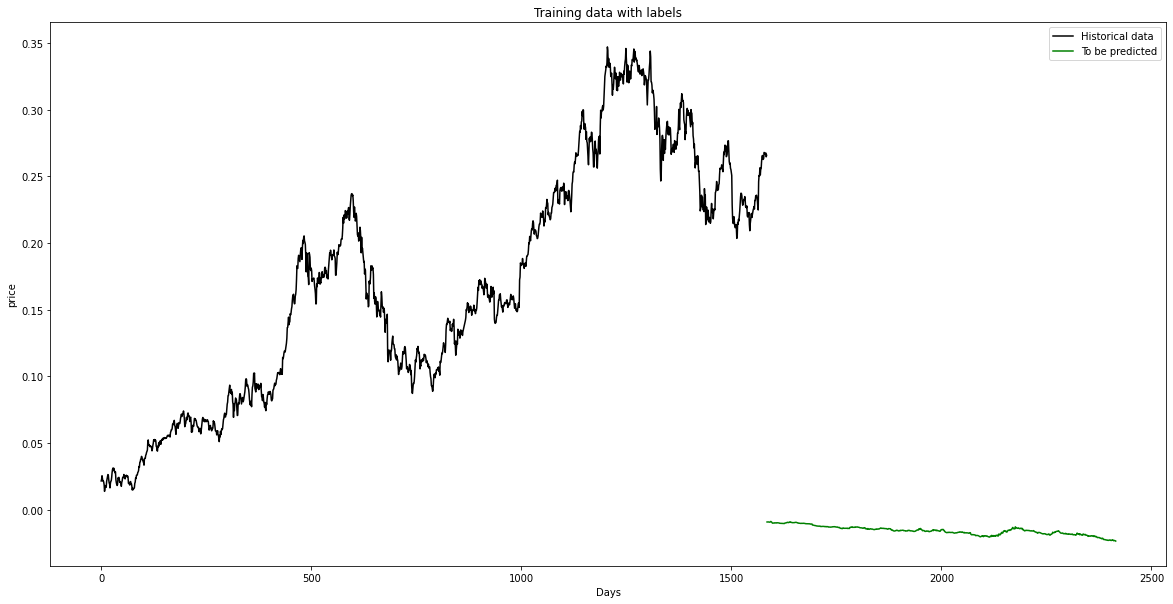

In [96]:
plt.rcParams["figure.figsize"] = (20,10)

day = 20
#print(data[day])
plt.plot(range(0, data.shape[0]), data[:,49], 'k-', label = 'Historical data')
plt.plot(range(data.shape[0], data.shape[0]+predictions.shape[0]), predictions[:,0,:], 'g-', label = 'To be predicted')
'''
plt.axvline(x=49, c = 'r')
plt.plot(49, data[day][49], 'rx', markersize = 20, label = "Today")
plt.xticks(range(0, 53), range(-49, 4))
'''
plt.title('Training data with labels')
plt.xlabel('Days')
plt.ylabel('price')
plt.legend()
plt.show()